<a href="https://colab.research.google.com/github/PiehTVH/COVID-QU-Ex/blob/main/COVID_QU_Ex_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19_Xray_Classifier
##Content
* Installation of packages
* Exploratory Data Analysis
* Modelling

In [ ]:
#Dataset: https://www.kaggle.com/datasets/anasmohammedtahir/covidqu
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d 'anasmohammedtahir/covidqu'

100% 1.15G/1.15G [01:05<00:00, 20.1MB/s]
100% 1.15G/1.15G [01:05<00:00, 18.9MB/s]


In [ ]:
!unzip 'covidqu.zip'

#Installation of packages


In [ ]:
!pip install livelossplot

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import glob
import shutil
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import joblib
import random
import pickle
import albumentations as A
import keras
import matplotlib.cm as cm
import plotly
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot.inputs.keras import PlotLossesCallback

from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

In [ ]:
'''
  Data_path_format_for_classification

         -> train
              + covid
                    -> xxx.jpg
              + noncovid
              + normal
         -> test
         -> valid
'''

main_path = './data'
if not os.path.exists(main_path):
  os.mkdir(main_path)

path = ['Train', 'Val', 'Test']
for i in path:
  dataset_path = os.path.join(main_path, i)
  if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)

files = ['COVID-19', 'Non-COVID', 'Normal']
for i in path:
  for j in files:
    file_dir = os.path.join(main_path, i,j)
    if not os.path.exists(file_dir):
      os.mkdir(file_dir)

ori_path = '/content/Lung Segmentation Data/Lung Segmentation Data'
for i in path:
  for j in files:
    for img in glob.glob(os.path.join(ori_path, i, j, 'images','*.png')):
      des = os.path.join(main_path, i,j)
      shutil.copy(img, des)

data_dir = os.path.join(main_path)

In [ ]:
# create dataframe
def create_df(file_name):
  data = []
  for id, level in enumerate(files):
    for file in os.listdir(os.path.join(data_dir, file_name +'/'+ level )):
      data.append([level + '/' + file, level ])

  data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])
  data['path'] = main_path + '/'+ file_name +'/' + data['image_file']
  data['corona_result'] = data['corona_result'].map({'COVID-19': 'Covid_positive', 'Non-COVID': 'Lung_positive', 'Normal':'Normal'})
  return data

In [ ]:
data_train = create_df('Train')
data_train.head()

,image_file,corona_result,path
0,COVID-19/sub-S11247_ses-E20029_run-1_bp-chest_...,Covid_positive,./data/Train/COVID-19/sub-S11247_ses-E20029_ru...
1,COVID-19/sub-S10082_ses-E17355_run-1_bp-chest_...,Covid_positive,./data/Train/COVID-19/sub-S10082_ses-E17355_ru...
2,COVID-19/sub-S09995_ses-E26500_run-1_bp-chest_...,Covid_positive,./data/Train/COVID-19/sub-S09995_ses-E26500_ru...
3,COVID-19/covid_2171.png,Covid_positive,./data/Train/COVID-19/covid_2171.png
4,COVID-19/sub-S10400_ses-E18029_run-1_bp-chest_...,Covid_positive,./data/Train/COVID-19/sub-S10400_ses-E18029_ru...


In [ ]:
data_test = create_df("Test")
data_test.head()

,image_file,corona_result,path
0,COVID-19/covid_2689.png,Covid_positive,./data/Test/COVID-19/covid_2689.png
1,COVID-19/sub-S09456_ses-E16274_run-1_bp-chest_...,Covid_positive,./data/Test/COVID-19/sub-S09456_ses-E16274_run...
2,COVID-19/sub-S09337_ses-E21345_run-1_bp-chest_...,Covid_positive,./data/Test/COVID-19/sub-S09337_ses-E21345_run...
3,COVID-19/sub-S12429_ses-E24954_run-1_bp-chest_...,Covid_positive,./data/Test/COVID-19/sub-S12429_ses-E24954_run...
4,COVID-19/sub-S09443_ses-E16693_run-1_bp-chest_...,Covid_positive,./data/Test/COVID-19/sub-S09443_ses-E16693_run...


In [ ]:
data_val = create_df("Val")
data_val.head()

,image_file,corona_result,path
0,COVID-19/sub-S09687_ses-E17602_run-1_bp-chest_...,Covid_positive,./data/Val/COVID-19/sub-S09687_ses-E17602_run-...
1,COVID-19/covid_2058.png,Covid_positive,./data/Val/COVID-19/covid_2058.png
2,COVID-19/sub-S12180_ses-E25771_run-1_bp-chest_...,Covid_positive,./data/Val/COVID-19/sub-S12180_ses-E25771_run-...
3,COVID-19/sub-S09603_ses-E16688_run-1_bp-chest_...,Covid_positive,./data/Val/COVID-19/sub-S09603_ses-E16688_run-...
4,COVID-19/sub-S09530_ses-E16370_run-1_bp-chest_...,Covid_positive,./data/Val/COVID-19/sub-S09530_ses-E16370_run-...


In [ ]:
print('Number of Duplicated Samples: %d'%(data_train.duplicated().sum()))
print('Number of Total Samples: %d'%(data_train.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 21715


#Exploratory Data Analysis

In [ ]:
no_of_samples = 21715
df_train = pd.DataFrame()
df_train['corona_result'] = ['Covid_positive', 'Lung_positive', 'Normal']
df_train['Count'] = [len(data_train[data_train['corona_result'] == 'Covid_positive']),
                      len(data_train[data_train['corona_result'] == 'Lung_positive']),
                       len(data_train[data_train['corona_result'] == 'Normal'])]
df_train = df_train.sort_values(by = ['Count'])

fig = px.bar(df_train, x = 'corona_result', y = 'Count',
             color = 'corona_result', width = 600,
             color_continuous_scale = 'BrBg')

fig.update_traces(textfont_size = 12, 
                  textangle = 0, 
                  textposition = "outside", 
                  cliponaxis = False)


fig.show()

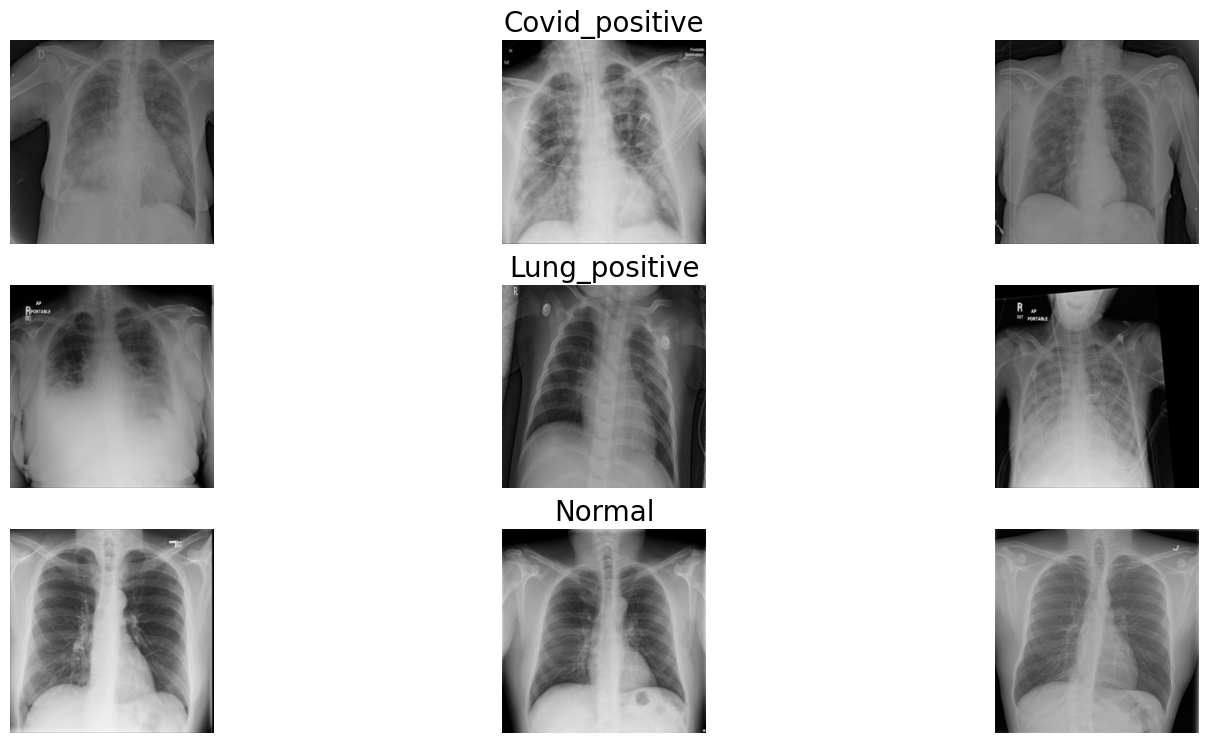

In [ ]:
##Printing random images from ALL
n_samples = 3
fig, m_axs = plt.subplots(3, n_samples, figsize = (6*n_samples, 3*3))

for n_axs, (type_name, type_rows) in zip(m_axs, data_train.sort_values(['corona_result']).groupby('corona_result')):
  n_axs[1].set_title(type_name, fontsize = 20)
  for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):
    picture = c_row['path']
    image = cv2.imread(picture)
    c_ax.imshow(image)
    c_ax.axis('off')

In [ ]:
data_train['image'] = data_train['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))
data_train.head()

,image_file,corona_result,path,image
0,COVID-19/sub-S11247_ses-E20029_run-1_bp-chest_...,Covid_positive,./data/Train/COVID-19/sub-S11247_ses-E20029_ru...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,COVID-19/sub-S10082_ses-E17355_run-1_bp-chest_...,Covid_positive,./data/Train/COVID-19/sub-S10082_ses-E17355_ru...,"[[6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 5, 5, 5, 5, 5,..."
2,COVID-19/sub-S09995_ses-E26500_run-1_bp-chest_...,Covid_positive,./data/Train/COVID-19/sub-S09995_ses-E26500_ru...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,COVID-19/covid_2171.png,Covid_positive,./data/Train/COVID-19/covid_2171.png,"[[188, 119, 120, 121, 122, 123, 125, 126, 128,..."
4,COVID-19/sub-S10400_ses-E18029_run-1_bp-chest_...,Covid_positive,./data/Train/COVID-19/sub-S10400_ses-E18029_ru...,"[[15, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, ..."


###Trong bài sẽ sử dụng Plotly cho Visualization vì: 
* Nó được sử dụng rộng rãi cho static, interactive và animated visualization.
* Có lợi cho việc tạo ra những hình ảnh trực quan hóa mà có thể tương tác được trên web browser. 

In [ ]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0, no_of_samples):
  mean_val.append(data_train['image'][i].mean())
  std_dev_val.append(data_train['image'][i].std())
  max_val.append(data_train['image'][i].max())
  min_val.append(data_train['image'][i].min())

imageEDA = data_train.loc[:, ['image', 'corona_result', 'path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val


imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

imageEDA.head()

,image,corona_result,path,mean,stedev,max,min,subt_mean
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Covid_positive,./data/Train/COVID-19/sub-S11247_ses-E20029_ru...,76.750933,74.201432,-49,0,54.025499
1,"[[6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 5, 5, 5, 5, 5,...",Covid_positive,./data/Train/COVID-19/sub-S10082_ses-E17355_ru...,111.257067,70.973044,-15,0,19.519366
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Covid_positive,./data/Train/COVID-19/sub-S09995_ses-E26500_ru...,121.413156,70.136180,-26,0,9.363277
3,"[[188, 119, 120, 121, 122, 123, 125, 126, 128,...",Covid_positive,./data/Train/COVID-19/covid_2171.png,129.022044,47.852546,-44,0,1.754388
4,"[[15, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, ...",Covid_positive,./data/Train/COVID-19/sub-S10400_ses-E18029_ru...,125.794311,45.882914,-48,0,4.982121


In [ ]:
mean_covid = imageEDA['mean'].loc[(imageEDA['corona_result'] == 'Covid_positive')].to_numpy()
mean_lung = imageEDA['mean'].loc[(imageEDA['corona_result'] == 'Lung_positive')].to_numpy()
mean_normal = imageEDA['mean'].loc[(imageEDA['corona_result'] == 'Normal')].to_numpy()

mean_list = [mean_covid, mean_lung, mean_normal]

max_covid = imageEDA['max'].loc[(imageEDA['corona_result'] == 'Covid_positive')].to_numpy()
max_lung = imageEDA['max'].loc[(imageEDA['corona_result'] == 'Lung_positive')].to_numpy()
max_normal = imageEDA['max'].loc[(imageEDA['corona_result'] == 'Normal')].to_numpy()

max_list = [max_covid, max_lung, max_normal]

min_covid = imageEDA['min'].loc[(imageEDA['corona_result'] == 'Covid_positive')].to_numpy()
min_lung = imageEDA['min'].loc[(imageEDA['corona_result'] == 'Lung_positive')].to_numpy()
min_normal = imageEDA['min'].loc[(imageEDA['corona_result'] == 'Normal')].to_numpy()

min_list = [min_covid, min_lung, min_normal]

std_covid = imageEDA['min'].loc[(imageEDA['corona_result'] == 'Covid_positive')].to_numpy()
std_lung = imageEDA['min'].loc[(imageEDA['corona_result'] == 'Lung_positive')].to_numpy()
std_normal = imageEDA['min'].loc[(imageEDA['corona_result'] == 'Normal')].to_numpy()

std_list = [std_covid, std_lung, std_normal]

Names = ['Covid', 'Lung', 'Normal']


##Trong bài sẽ plot các giá trị max, min, mean distribution và biểu đồ phân tác Mean - Standard deviation. Nguyên nhân là bởi:
* Hiểu được các đặc tính của bộ data.
* Xác định các Potential Issues và Trends.
* Xác định mô hình và correlation (ở biểu đồ phân tán Mean - Standard Deviation).
###Vd: Ở Max Value Distribution, nếu phân bố có xu hướng lệch về một bên => có lượng nhiễu lớn.
###Ngược lại, ta có thể hiểu là bộ data cân bằng và có thể làm việc với nó dễ hơn.

In [ ]:
def min_max_plot(data, name, title):
  colors = ['#04EEFF', '#4BBBFF', '#F5F232', '#7FFF00']

  fig = ff.create_distplot(data, name, show_hist = False, colors = colors)
  fig.update_layout(title_text = title,
                    titlefont = {'size':30},
                    template = 'plotly_dark',
                    width = 800, height = 600)
  fig.show()

In [ ]:
#Plotting Max Value Distribution
min_max_plot(max_list, Names, 'Images Colour Max Value Distribution by Class')

In [ ]:
#Plotting Min Value Distribution
min_max_plot(min_list, Names, 'Images Colour Min Value Distribution by Class')

In [ ]:
#Plotting Mean Value Distribution
min_max_plot(mean_list,Names,"Images Colour Mean Value Distribution by Class")


In [ ]:
#Plotting Mean vs Standard Deviation of Images
fig = px.scatter(imageEDA, x = 'mean', y = 'stedev', color = 'corona_result',
                 color_discrete_sequence = px.colors.qualitative.Set3)
fig.update_layout(title_text = 'Mean and Standard Deviation of Image Samples',
                  xaxis_title = 'Image Channel Colour Mean',
                  yaxis_title = 'Image Channel Colour Standard Deviation',
                  titlefont = {'size': 30},
                  template = 'plotly_dark',
                  width = 800, height = 600,)
fig.show()

###Printing random images from all classes


In [ ]:
def random_analysis(image_path):

    image = cv2.imread(image_path)

    # create figure
    fig = plt.figure(figsize=(10, 7))

    # setting values to rows and column variables
    rows = 2
    columns = 3

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)
    plt.title('Original ', fontsize = 14)

    plt.imshow(image)
    plt.axis('off')


    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)

    # showing image
    plt.title('B channel', fontsize = 14)
    plt.imshow(image[ : , : , 0])
    plt.axis('off');


    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 3)

    img = cv2.imread(image_path)
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    plt.title("Ben Graham's Method", fontsize = 14)
    plt.imshow(img)
    plt.axis('off')
    
    list_text = image_path.split("/")

    print("\n-----------------------------{}-----------------------------\n".format("IMAGE DETAILS" + " ( " + list_text[5].upper() + " )"))

    print('Image Shape: {}'.format(image.shape))
    print('Image Height: {}'.format(image.shape[0]))
    print('Image Width: {}'.format(image.shape[1]))
    print('Image Dimension: {}'.format(image.ndim))
    print('Image Size: {}kb'.format(image.size//1024))
    print('Image Data Type: {}'.format(image.dtype))
    print('Maximum RGB value of the image: {}'.format(image.max()))
    print('Minimum RGB value of the image: {}'.format(image.min()))

In [ ]:
list_images_sample=['/content/Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19/images/covid_1000.png',
                   '/content/Lung Segmentation Data/Lung Segmentation Data/Train/Non-COVID/images/Non_COVID (46).png',
                    '/content/Lung Segmentation Data/Lung Segmentation Data/Train/Normal/images/Normal (10295).png']


-----------------------------IMAGE DETAILS ( COVID-19 )-----------------------------

Image Shape: (256, 256, 3)
Image Height: 256
Image Width: 256
Image Dimension: 3
Image Size: 192kb
Image Data Type: uint8
Maximum RGB value of the image: 239
Minimum RGB value of the image: 27


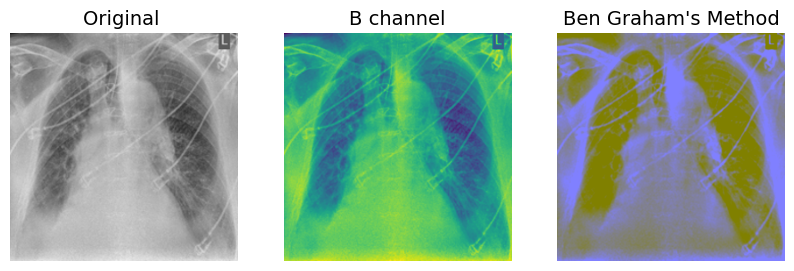

In [ ]:
random_analysis(list_images_sample[0])



-----------------------------IMAGE DETAILS ( NON-COVID )-----------------------------

Image Shape: (256, 256, 3)
Image Height: 256
Image Width: 256
Image Dimension: 3
Image Size: 192kb
Image Data Type: uint8
Maximum RGB value of the image: 220
Minimum RGB value of the image: 0


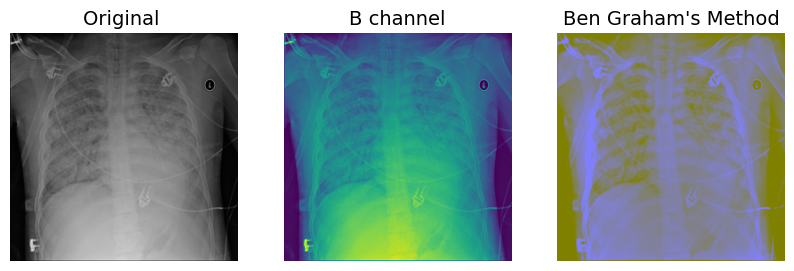

In [ ]:
random_analysis(list_images_sample[1])



-----------------------------IMAGE DETAILS ( NORMAL )-----------------------------

Image Shape: (256, 256, 3)
Image Height: 256
Image Width: 256
Image Dimension: 3
Image Size: 192kb
Image Data Type: uint8
Maximum RGB value of the image: 250
Minimum RGB value of the image: 0


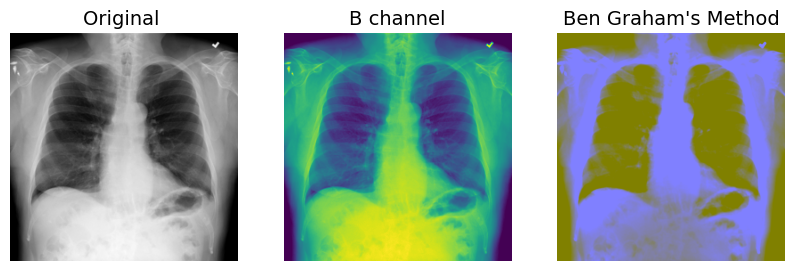

In [ ]:
random_analysis(list_images_sample[2])


In [ ]:
#Use of albumentation
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ''):
  fig, axs = plt.subplots(figsize = (15,8), nrows = 2, ncols = ncols, squeeze = False)
  plt.suptitle(main_title, fontsize = 18)
  fig.subplots_adjust(wspace = 0.3)
  fig.subplots_adjust(hspace = 0.3)

  for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
    axs[i//ncols][i%ncols].imshow(img)
    axs[i//ncols][i%ncols].set_title(title, fontsize = 15)

  plt.show()

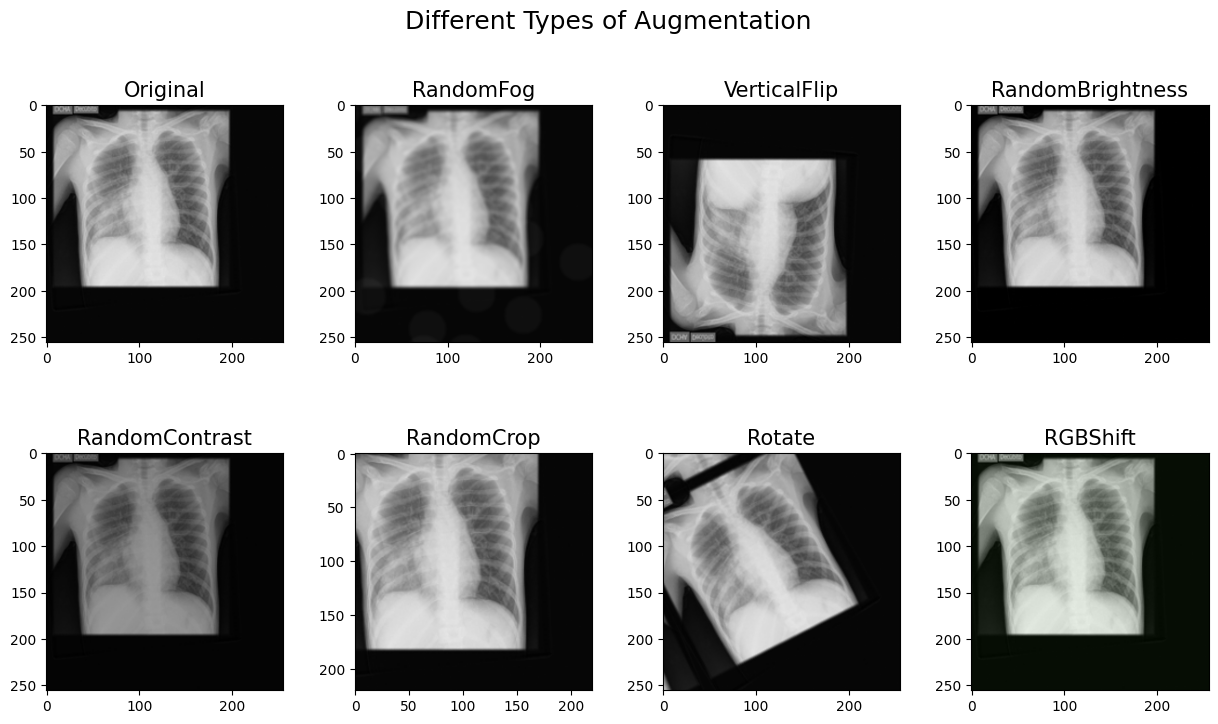

In [ ]:
chosen_image = cv2.imread('/content/data/Train/COVID-19/covid_101.png')
albumentation_list = [A.RandomFog(p = 1),
                    A.VerticalFlip(p = 1),
                    A.RandomBrightness(p = 1),
                    A.RandomContrast(limit = 0.6, p = 1),
                    A.RandomCrop(p = 1, height = 220, width = 220),
                    A.Rotate(p = 1, limit = 90),
                    A.RGBShift(p = 1)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
  img = aug_type(image = chosen_image)['image']
  img_matrix_list.append(img)

img_matrix_list.insert(0, chosen_image)

title_list = ['Original', 'RandomFog', 'VerticalFlip', 'RandomBrightness',
              'RandomContrast', 'RandomCrop', 'Rotate', 'RGBShift']

plot_multiple_img(img_matrix_list, title_list, ncols = 4, main_title = 'Different Types of Augmentation')

#Modelling

In [ ]:
def create_dataset(data):
  x = []
  y = []
  {'COVID-19': 'Covid_positive', 'Non-COVID':'Lung_positive', 'Normal':'Normal'}

  for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    #Vì bị tràn RAM nên lựa chọn ảnh có kích thước 70x70 là vừa vặn nhất
    image = cv2.resize(image, (70,70)) /255.0               
    label = 0

    if data['corona_result'][i] == 'Normal':
      label = 0
      x.append(image)
      y.append(label)
    elif data['corona_result'][i] == 'Covid_positive':
      label = 1
      x.append(image)
      y.append(label)
    else:
      label = 2
      x.append(image)
      y.append(label)

  return np.array(x), np.array(y)

In [ ]:
x_train, y_train = create_dataset(data_train)
x_val, y_val = create_dataset(data_val)

In [ ]:
print(len(data_train))
print(len(data_val))
print(len(data_test))

print(len(x_train))
print(len(x_val))
# print(len(x_test))

21715
5417
6788
21715
5417


In [ ]:
# print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

In [ ]:
def create_model_Sep(n_classes, train_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = train_shape))
    model.add(layers.Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
    model.add(layers.SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
    model.add(layers.SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))


    # model.add(layers.SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
    # model.add(layers.SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
    # model.add(layers.BatchNormalization())
    # model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = 'relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(units = 3))

    model.compile(optimizer = 'adam', 
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
               metrics = ['accuracy'])

    model.summary()
    return model

In [ ]:
input_shape = (70, 70, 3)
n_classes= 3

model = create_model_Sep(n_classes, input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 70, 70, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 70, 70, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 35, 16)       0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 35, 35, 32)       688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 35, 35, 32)       1344      
 leConv2D)                                                       
                                                        

In [ ]:
# !pip install tensorflow_addons

In [ ]:
##Callback definition
tl_checkpoint_1 = ModelCheckpoint(filepath='best_weights.hdf5',
                                  save_best_only=True,
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=10, 
                              verbose=2, mode='max')


###Đôi nét về PlotLossesCallback()
* Là một hàm trong thư viện livelossplot.
* Cho phép plot training và validation trong quá trình training.
* Cập nhật plot với real time. 

=> Giúp ta hiểu được performance của model trong quá trình training, xác định trends của accuracy-loss và debugging.

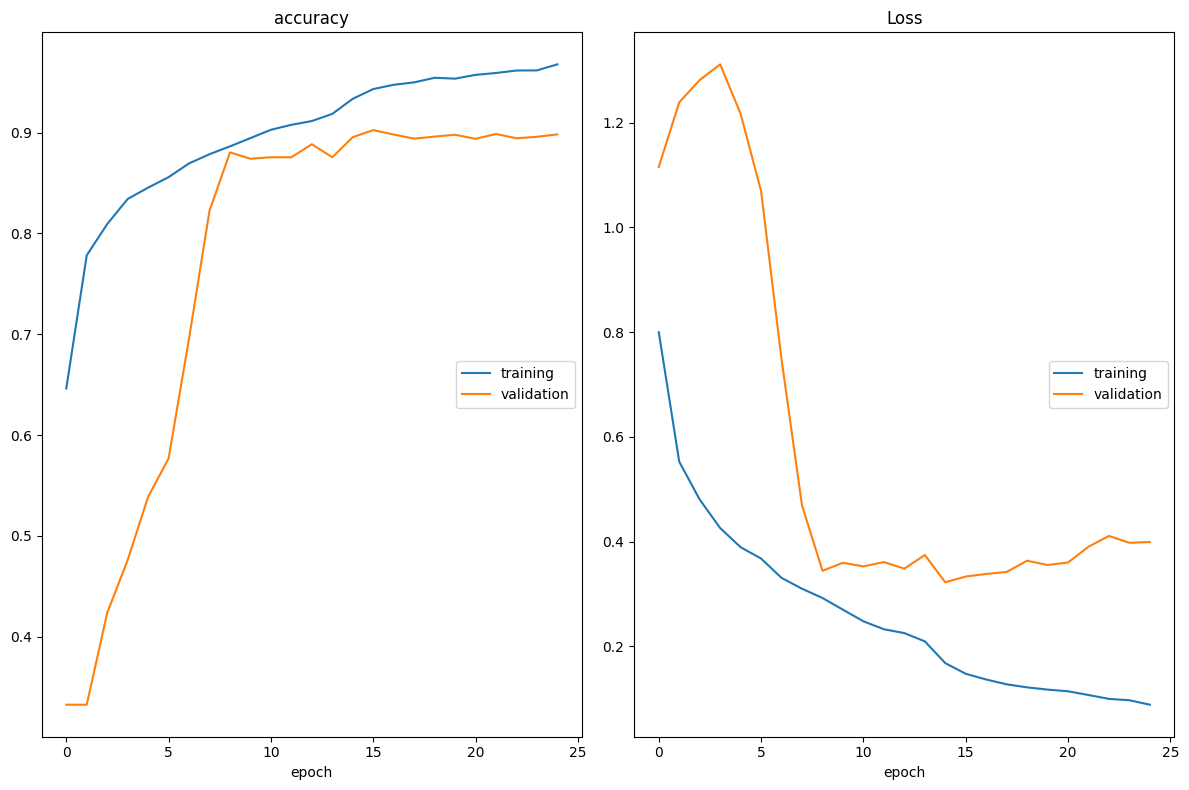

accuracy
	training         	 (min:    0.646, max:    0.968, cur:    0.968)
	validation       	 (min:    0.333, max:    0.903, cur:    0.898)
Loss
	training         	 (min:    0.088, max:    0.800, cur:    0.088)
	validation       	 (min:    0.322, max:    1.312, cur:    0.399)
85/85 [==============================] - 6s 65ms/step - loss: 0.0884 - accuracy: 0.9677 - val_loss: 0.3992 - val_accuracy: 0.8983 - lr: 4.0000e-05


In [ ]:
plot_loss_1 = PlotLossesCallback()

hist = model.fit(x_train, y_train, 
                        epochs = 100, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [tl_checkpoint_1, early_stop, plot_loss_1, lr_reduce],
                       verbose=1)


In [ ]:
#85/85 [==============================] - 6s 65ms/step - loss: 0.0884 - accuracy: 0.9677 - val_loss: 0.3992 - val_accuracy: 0.8983 - lr: 4.0000e-05

In [ ]:
y_train_pred = model.predict(x_train)
y_train_pred = np.argmax(y_train_pred, axis = 1)
y_val_pred = model.predict(x_val)
y_val_pred = np.argmax(y_val_pred, axis = 1)
# y_test_pred = model.predict(x_test)
# y_test_pred = np.argmax(y_test_pred, axis = 1)

170/170 [==============================] - 1s 4ms/step


In [ ]:
def confusion_matrix_train_test_val(name, y_train, y_train_pred, y_val, y_val_pred):
  #, y_test, y_test_pred):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, y_train_pred)) 
    print("--------------------------------------------------------------------------")
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, y_val_pred))   
    print("--------------------------------------------------------------------------")

    
    # print("\nClassification Report for Test Data\n")
    # print(classification_report(y_test, y_test_pred))   
    # print("--------------------------------------------------------------------------")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

confusion_matrix_train_test_val("CNN", y_train, y_train_pred, y_val, y_val_pred) #, y_test, y_test_pred)



-----------------------------CNN-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      6849
           1       0.99      1.00      0.99      7658
           2       0.99      0.89      0.94      7208

    accuracy                           0.96     21715
   macro avg       0.96      0.96      0.96     21715
weighted avg       0.96      0.96      0.96     21715

--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1712
           1       0.94      0.96      0.95      1903
           2       0.91      0.82      0.86      1802

    accuracy                           0.90      5417
   macro avg       0.90      0.89      0.89      5417
weighted avg       0.90      0.90      0.90      5417

-----------------

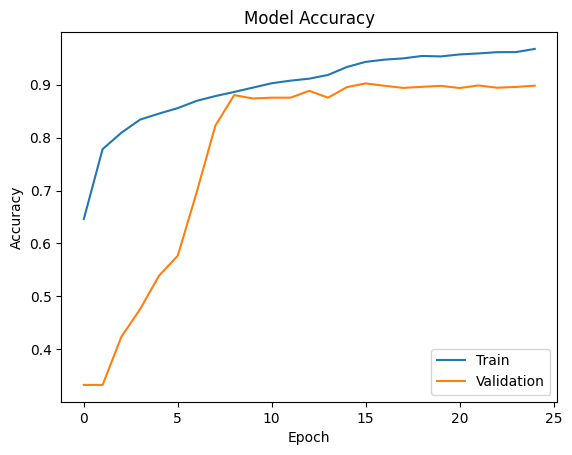

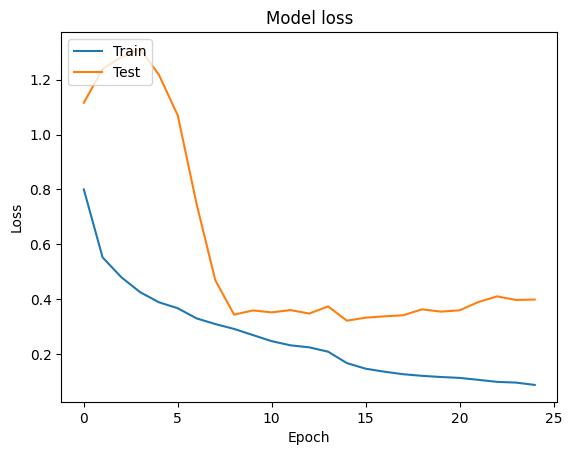

In [ ]:
# lot training & validation Accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()


#Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##Predicting

In [ ]:
pkl_Filename = "Pickle_Model.pkl"  

with open(pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [ ]:
hist.model.save("model.pkl")

In [ ]:
model.save("model_2.h5")

In [ ]:
joblib_file = "model_2.pkl"  
joblib.dump(model, joblib_file)



['model_2.pkl']

In [ ]:
loaded_model = pickle.load(open("Pickle_Model.pkl", 'rb'))
loaded_model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f443c8bd280>>

In [ ]:
from tensorflow.keras.models import load_model
down_size = (70,70)
img_path = '/content/data/Test/Non-COVID/non_COVID (11197).png' #1

img = cv2.imread(img_path)
img = cv2.resize(img, down_size)
#img = np.dstack([img, img, img])
img = img.astype('float32') / 255

#print(img)
input_data = img.reshape((-1, 70, 70, 3))
    # load model
model_x = load_model("model_2.h5", compile = True)

pred = model_x.predict(input_data)
classes = np.argmax(pred )
print(classes)


1/1 [==============================] - 0s 388ms/step
1


In [ ]:
# model2 = load_model("covid_model.h5")

##Visualize Grad - CAM

###Vì sao cần Grad-CAM?
* Đây là một kỹ thuật giúp ta hiểu được phần nào của Image là quan trọng cho prediction của model.
* Nó tạo ra heatmap, làm nổi bật vùng sensitive với model khi thực hiện prediction.

In [ ]:
#Reference: https://keras.io/examples/vision/grad_cam/

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299,299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

last_conv_layer_name = "block14_sepconv2_act"


In [ ]:
def get_img_array(img_path, size):
  img = keras.preprocessing.image.load_img(img_path, target_size = size)
  array = keras.preprocessing.image.img_to_array(img)
  array = np.expand_dims(array, axis = 0)
  return array

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()  

In [ ]:
list_images_sample

['/content/Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19/images/covid_1000.png',
 '/content/Lung Segmentation Data/Lung Segmentation Data/Train/Non-COVID/images/Non_COVID (46).png',
 '/content/Lung Segmentation Data/Lung Segmentation Data/Train/Normal/images/Normal (10295).png']

In [ ]:
# Storing Heatmap values into list
covid_noncovid_heatmap = []

for i in list_images_sample:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model_builder(weights = "imagenet")
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    covid_noncovid_heatmap.append(heatmap)

1/1 [==============================] - 1s 721ms/step


1/1 [==============================] - 1s 702ms/step


In [ ]:
import matplotlib.cm as cm
def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    
    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))


for i in range(len(list_images_sample)):
    save_and_display_gradcam(list_images_sample[i], covid_noncovid_heatmap[i])

<ipython-input-64-d3e7bcb82fe5>:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [ ]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 1, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()

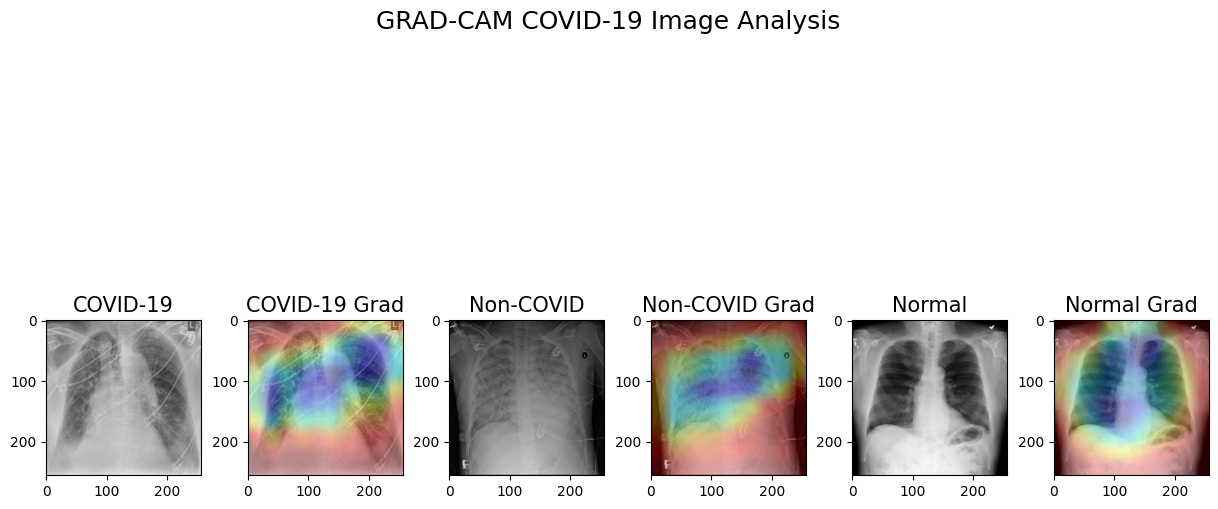

In [ ]:
titles_list = ["COVID-19",'COVID-19 Grad','Non-COVID','Non-COVID Grad','Normal','Normal Grad']
plot_multiple_img(imag, titles_list, ncols = 6, main_title = "GRAD-CAM COVID-19 Image Analysis")

##End